<table>
  <tr>
    <td><p style="font-size:45px; color: #55BBD2">Analysis of light microscopy images in Python</p></td>
    <td><img src="ressources/lmb_logo.svg" alt="LMB Logo" width="500" height="600" align="right"></td>
  </tr>
</table>
<table>
  <tr>
    <td><p style="font-size:15px; color: #55BBD2">Version: July 2023</p></td>
  </tr>
</table>

# Introduction

## Short remarks
short intro to the aim of the course
short Intro to Python,  Python packages, installing and packages
how to run a jupyter notebook
download images



## Downloading data

Let us first download some data. 
Please run the next cell.

In [1]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

url = 'https://cloud.mrc-lmb.cam.ac.uk/s/apiQPm28YLRWXeo/download/data.zip'
data_folder = './'
download_and_unzip(url, data_folder)

from pathlib import Path
print(f'List of files in the {data_folder}data folder')
for x in (Path(data_folder) / 'data').glob('*'):
    print(f' {str(x.name)}')
 

List of files in the ./data folder
 target.lif
 example.tif
 airyscan-4colors.tif
 example.czi
 example.nd2
 nuclei.tif
 tetrahymena.nd2


# Analysis problem




![title](ressources/data.png)

 Let say we are interested in what is happening in each channel within the actin region (Channel-1) that surround each nuclei (Channel-3). Our region of interest (ROI) is therefore defined by the actins in Channel-1 that have as a "seed" the nuclei in Channel-3. We want to measure:
- the maximal intensity in Channel-0 within this ROI,
- the integrated intensity in Channel-1 within this ROI,
- the median intensity of Channel-2 of the ROI within this ROI  

That is enough problem for now so let's get into it :)

To solve the problem and achieve the statistic analysis, we generally need to do the following steps:
- Load the image
- Filter the image
- Segment the image
- Measure image properties
- Save the data


 
This notebook shows how can we extract statistical information from an image (e.g. finding the maximal intensity in a desired region of interest). The steps that we need to follow to achieve this mainly depend on the exact problem we want to solve but in general it consists of: 

    Step 1: load and read the image (load-data.ipynb)
    Step 2: pre-process the image if necessary such as noise filtering (filter-image.ipynb)
    Step 3: find the region of interest: edge or inside the region? 
    Step 4: extract the desired information in the region of interest: mean, max, min, sum, median, mode, ...
    Step 5: display/plot results
    Step 6: save the result in a given image format or values in a text/excel file

# Loading microscopy image data

- How to load an image explain that there are different packages for different image types
- We use aicsimageio - Why?, Depending on your image format you can use a different package
- explain bioformats

When opening an image:
- You need to specify the path of the image
- Make sure to have the path correct and on MS Windows use / instead of \

Load the image with its metadata in this next cell by replacing the image path directory in that cell.


In [43]:
from aicsimageio import AICSImage

image = AICSImage('data/tetrahymena.nd2')

image.data
image.metadata
image.physical_pixel_sizes
image.shape
image.dims
image.channel_names

['DIC Camera']

The image and its metadata are now loaded into the variable "mydata".



What is metadata.
Next, we read the image and the metadata. Metadata includes the number of channels in the images, the name of each channel and emission wavelength associated with each channel, the voxel size and physical size of the image. Many other acquisition parameters are stored in the metadata and we can access them from here.


Let's load the data we'll use along this lession:

In [44]:
image = AICSImage('data/airyscan-4colors.tif')

for k, i in enumerate(image.dims.order):
    print(f'Array axis {k} is {i} with size {image.dims[i][0]}')

print(f'The name of the channels are {image.channel_names}')
print(f'The pixel size in X is {image.physical_pixel_sizes.X:.4f} microns')
print(f'The pixel size in Y is {image.physical_pixel_sizes.Y:.4f} microns')

Array axis 0 is T with size 1
Array axis 1 is C with size 4
Array axis 2 is Z with size 1
Array axis 3 is Y with size 1912
Array axis 4 is X with size 1912
The name of the channels are ['Channel:0:0', 'Channel:0:1', 'Channel:0:2', 'Channel:0:3']
The pixel size in X is 0.0353 microns
The pixel size in Y is 0.0353 microns


- now lets extract image data and look at it.
- what is an image?
- explain image dimensions

In [45]:
# import the numpy package used for manipulating images
import numpy as np

# get the array of pixels intensity as a numpy object
data = image.data

# Print the type of the array
print('The data is a ', type(data)) 

# Print the dimension of the array
print('The array has the following shape', data.shape) 


The data is a  <class 'numpy.ndarray'>
The array has the following shape (1, 4, 1, 1912, 1912)


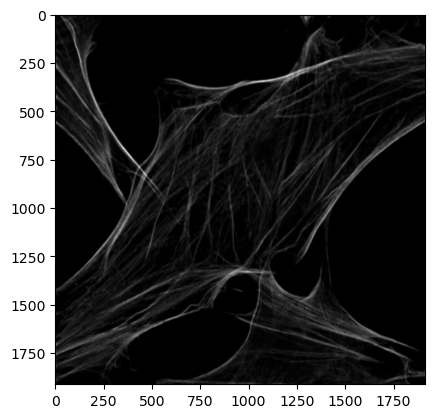

In [46]:
# import matplotlib for loading images
import matplotlib.pyplot as plt

# Let's display a 2D image in a figure
plt.imshow(data[0,1,0,:,:], cmap='gray');


Let's display each channel of the image:

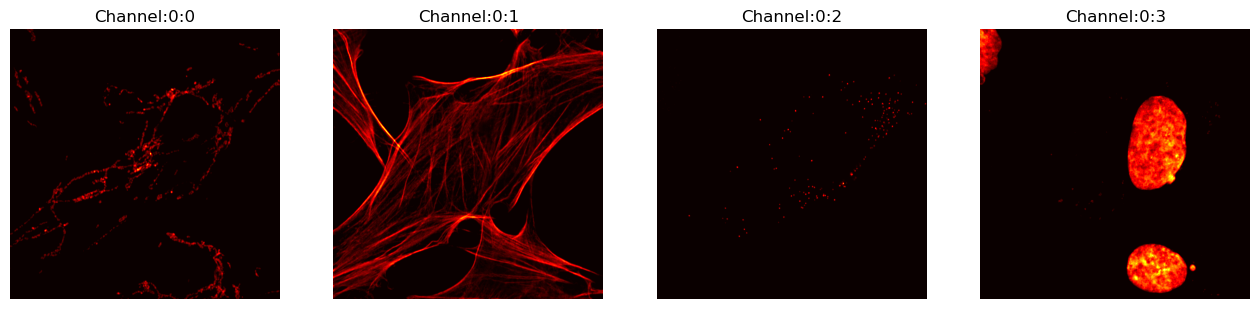

In [50]:
# import matplotli for displaying images
import matplotlib.pyplot as plt

# compute the number of channels
num_channels = image.shape[1]

# Display the image for each channel
fig, ax = plt.subplots(1, num_channels, figsize=(16,4))
for k  in range(num_channels):    
    ax[k].imshow(image.data[0,k,0], cmap='hot')
    ax[k].set_axis_off()
    ax[k].set_title(image.channel_names[k])    

An image is a multi-dimensional array of pixels.

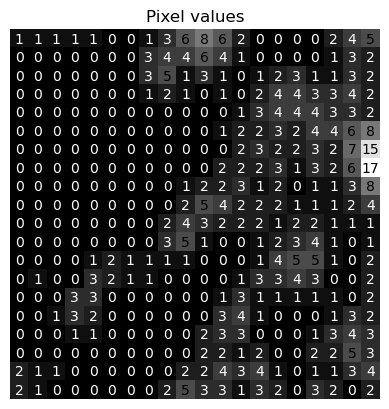

In [48]:
# Crop and downsample the array by a factor of 5
crop = image.data[0, 0, 0, 850:950:5, 900:1000:5]

# Create a figure with axes
fig, ax = plt.subplots()

# Display the downsampled array in the figure
plt.imshow(crop, cmap='gray')

# Add the values of the pixel intensity
for i in range(crop.shape[0]):
    for j in range(crop.shape[1]):
        c = 'white' if crop[i, j] < 5 else 'black'
        ax.text(j, i, str(int(crop[i, j])), color=c, ha='center', va='center', size=10)
ax.axis("off")
plt.title('Pixel values');

# Image Filtering and Noise

Noise in microscopic image is unavoidable during image acquisition. There are three main categories of noise: 
1)Photon noise, also called fluorescence noise or shot noise: acquired due to the fluctuation of photon emission to the detector. This is the most dominant noise. It is signal dependent and follows a Poisson distribution. 
2) Electronic noise, also called dark current or dark noise: accumulated over time due to thermal change as the detector heats up. It is unavoidable but negligible compared to photon noise and is not photon dependent. It follows Poisson distribution. 
3) Readout noise: digital noise acquired during the electronic quantisation of photons. It follows a Gaussian distribution where the standard deviation is constant and the mean is 0.

Dominant noise in fluorescence microscopy follows either a Gaussian distribution or Poisson distribution or both. Gaussian noise is additive while Poisson noise is signal dependent. A correct removal of those two different types of noise may therefore differ. Firstly, we will look at how those noise affect the image differently. 

## Simulating noisy images

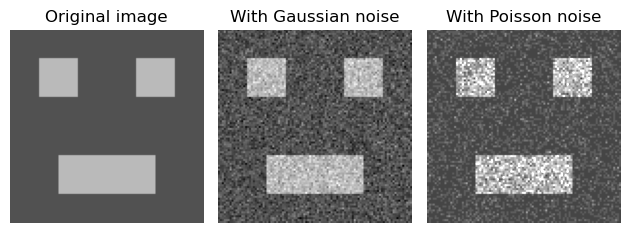

In [98]:
# Create a noise free test image
n = 100
nphotons = 5
data = np.zeros((n,n),dtype=float)+0.5
data[n//4-10:n//4+10, n//4-10:n//4+10] = nphotons
data[n//4-10:n//4+10, 3*n//4-10:3*n//4+10] = nphotons
data[3*n//4-10:3*n//4+10, n//4:3*n//4] = nphotons

# Add a Gaussian noise
mean = 0
stddev = 1
noisy_gauss_img = data + np.random.normal(mean, stddev, data.shape)

# Apply Poisson noise
noisy_poisson_img = np.random.poisson(data)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(data, cmap='gray',vmin=-3,vmax=nphotons+3)
axs[0].set_title('Original image')
axs[0].set_axis_off()

axs[1].imshow(noisy_gauss_img, cmap='gray',vmin=-3,vmax=nphotons+3)
axs[1].set_title('With Gaussian noise')
axs[1].set_axis_off()

axs[2].imshow(noisy_poisson_img, cmap='gray',vmin=-3,vmax=nphotons+3)
axs[2].set_title('With Poisson noise')
axs[2].set_axis_off()

fig.set_tight_layout('tight')


## Noise filtering

There are different types of noise reduction: smoothing filtering or convolution filtering, mean filtering, median filtering, and frequency filtering. An image can be treated as a matrix, or array in Python. Each pixel has a value which represents the image intensity at the spatial position of the pixel. To filter an image, we need to work on each pixel of the image.

### Gaussian filter
A smoothing filter uses the principle of convolution to reduce the noise. A convolution process is similar to drawing. The kernel is the pencil that is used for the drawing. So the sharpness of the drawn image really depends on the width of the point of the pencil. In the case of a Gaussian filtering, the Gaussian distribution is used as a kernel. When used for noise filterning, the noise which should have a lower intensity value than the real signal gets smoothed out because of this convolution process. Next, we will see below this process work.

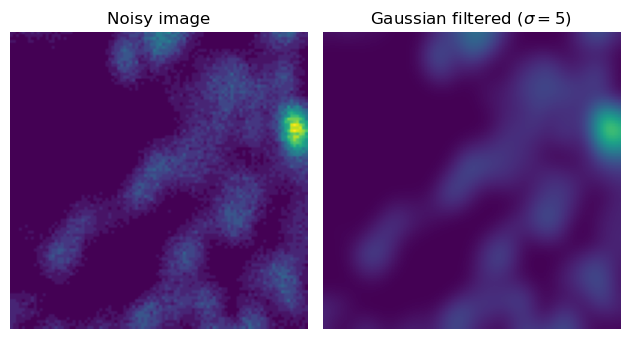

In [100]:
from skimage import filters

# Crop the image and select the first channel
crop = image.data[0, 0, 0, 850:950, 900:1000]

# Gaussian filtering of data with a Gaussian filter of scale 3
gaussian_filtered = filters.gaussian(crop.astype(float), 3)

fig, axs = plt.subplots(1, 2)
vmin, vmax = crop.min(), crop.max()

axs[0].imshow(crop, vmin = vmin, vmax = vmax)                      # original image
axs[0].set_title('Noisy image')
axs[0].set_axis_off()

axs[1].imshow(gaussian_filtered,vmin=vmin,vmax=vmax)                # with addition Gaussian noise
axs[1].set_title('Gaussian filtered ($\sigma=5$)')
axs[1].set_axis_off()

plt.tight_layout()


### Median filter
Different techniques for noise filtering are median and total variation (TV) filtering. With the median filter, each output pixel is computed as the median value of the input pixel under a chosen window. With TV filtering technique, the output image is an approximation of the input noisy image, which has a smaller total variation than the input image but is similar to the image. A total variation of an image measures how much the image changes between pixel values.

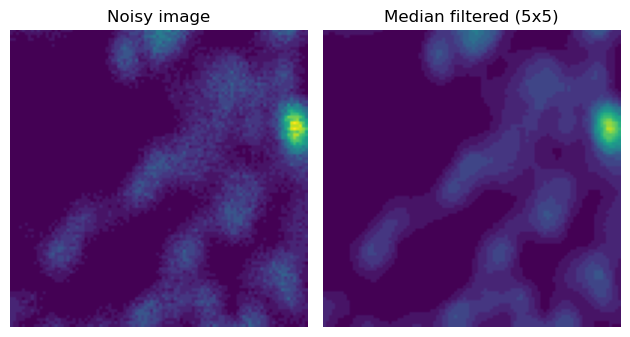

In [10]:

# The second argument in this function here defines the size of the kernel over 
# which the median is calculated
median_filtered = filters.median(crop, np.ones((5,5))) 

fig, axs = plt.subplots(1, 2)

# compute the min and max of the original image to keep the same display range
vmin, vmax = crop.min(), crop.max()

axs[0].imshow(crop, vmin = vmin, vmax = vmax)    
axs[0].set_title('Noisy image')
axs[0].set_axis_off()

axs[1].imshow(median_filtered,  vmin = vmin, vmax = vmax)    
axs[1].set_title('Median filtered (5x5)')
axs[1].set_axis_off()

plt.tight_layout()

# Segmentation

- what is segmentation
- what is a mask , label mask, ROI

The goal is to find masks which represents each ROI. The easiest way to do this by simply thresholding the intensity of the image. By this, the mask is defined such that only intensity (pixel) values greater than the threshold value are selected. If we stop at this stage, the problem we may encounter is such that some values within the thresholded region may get discarded because the intensity value is lower than the threshold and the ROI won't be filled. In this case, we may need to find the edge or/and fill the mask region. Another issue that we may encounter as well is that the edges of the regions may overlap so they may be detected or segmented as one. One solution in this case is to use what is called watershed segmentation to detect the flow of the intensity and decide from there whether the regions form only one object or different objects. 


## Thresholding 


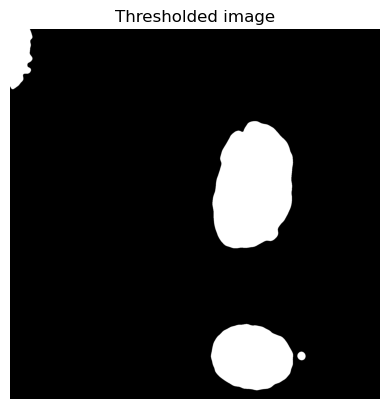

In [11]:
nuclei = image.data[0,3,0,:,:] # the object we want to segment and set as markers of our final ROI
nuclei_flt = filters.gaussian(nuclei.astype(float), 10) 

threshold = 5 # change threshold value here to see what happens to the mask that is being displayed below
mask = nuclei_flt >= threshold    
plt.imshow(mask, cmap='gray')
plt.title('Thresholded image')
plt.axis('off');

## Automated thresholding segmentation 
There is also one way to automatically detect the threshold that needs to be applied on the image in order to detect the nuclei region. This method was developed by Otsu and you can follow the link [here](https://en.wikipedia.org/wiki/Otsu%27s_method) if you want to learn more how does it work. So let us see now how can we do the thresholding using the Otsu's method and fill the mask. And since in microscopic images, we may have more than one nuleus (in our case we do have 2 full ones), we need to label each of the nuclei to distingush them and to be able to extract information from each of them. To achieve these, we need to load some packages first. 

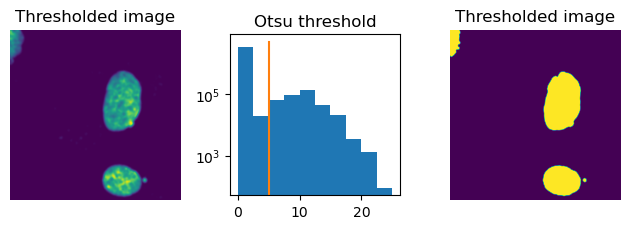

In [12]:
from skimage import filters

# find the threshold value differentiating the signal from background
threshold = filters.threshold_otsu(nuclei_flt) 

# define the threshold mask and close it
nuclei_mask = nuclei_flt > threshold

fig, ax = plt.subplots(1,3)

ax[0].imshow(nuclei_flt)
ax[0].set_title('Thresholded image')
ax[0].set_axis_off()

ax[1].hist(nuclei.ravel(),log=True)
ax[1].plot([threshold, threshold], [0,5e6])
ax[1].set_title('Otsu threshold')
ax[1].set_aspect(5)

ax[2].imshow(nuclei_mask)
ax[2].set_title('Thresholded image')
ax[2].set_axis_off()

plt.tight_layout()

Let's clean up the binary mask using morphology tools from scikit image.

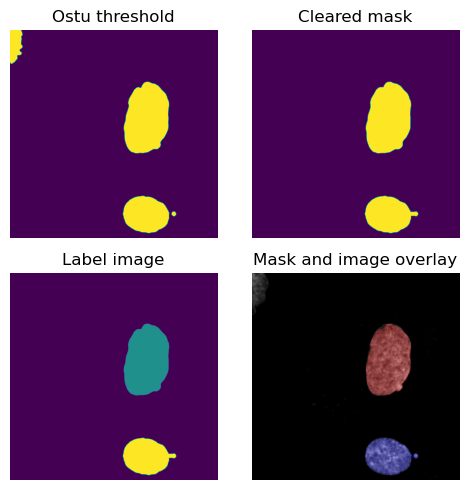

In [13]:
from skimage import morphology
from skimage import segmentation
from skimage import measure
from skimage import color

# remove artifacts connected to image border
cleared = morphology.closing(nuclei_mask, morphology.square(35))
cleared = segmentation.clear_border(cleared)

# label image regions
nuclei_label = measure.label(cleared)

# label image to rgb 
nuclei_label_overlay = color.label2rgb(nuclei_label, image=10*nuclei, bg_label=0)

fig, ax = plt.subplots(2, 2, figsize=(5,5))
ax[0,0].imshow(nuclei_mask)
ax[0,0].set_title('Ostu threshold')
ax[0,0].set_axis_off()

ax[0,1].imshow(cleared)
ax[0,1].set_title('Cleared mask')
ax[0,1].set_axis_off()

ax[1,0].imshow(nuclei_label)
ax[1,0].set_title('Label image')
ax[1,0].set_axis_off()

ax[1,1].imshow(nuclei_label_overlay)
ax[1,1].set_title('Mask and image overlay')
ax[1,1].set_axis_off()

plt.tight_layout()


## Watershed-based segmentation
The segmentation of the nuclei is pretty straightforward because they are well separated. In same cases however, the objects we want to segment overlap, making it difficult to discern the different regions. In this case, we would need to add extra step into the image segmentation in order to discern the objects. Watershed segmentation is useful for this purpose. It is generally used for separating different objects. Watershed algorithm treats pixels values as a local topography (elevation) so the goal is to follow the flow of the elevation and find the watershed lines from which the edge of each of the regions are deduced. We use this principle to extract our previously defined ROIs: the actin region in Channel-1 having the two nuclei as markers and the seeds of the segmentation. 

The steps that we need to follow for this are as follows: 
*  Step 1: threshold the actin to segment to obtain a region mask denoted by actin_mask from it
*  Step 2: calculate the distance transform of actin_mask, also known as distance map, which defines the spatial distance of each pixel value position to the background of the image
*  Step 3: define the markers or seeds of the segmentation as local maxima of the distance to the background (local minima of the image to segment and the opposite of the distance). We have this as the nuclei_label_image. 
*  Step 4: watershed the opposite of the distance transform from Step 2 within the mask in Step 1 and the nuclei markers 

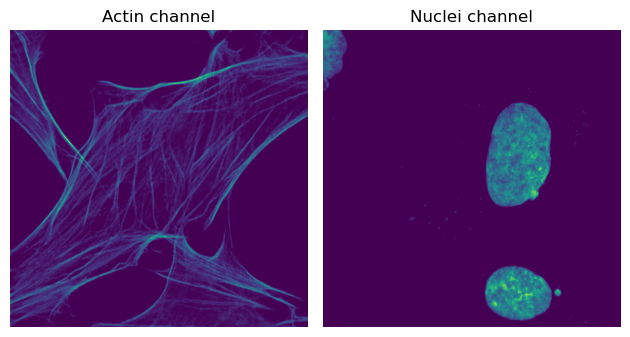

In [14]:
actin  = image.data[0,1,0,:,:] #  the channel we want to segment 

fig, axs = plt.subplots(1,2)
axs[0].imshow(actin)
axs[0].set_title('Actin channel')
axs[0].set_axis_off()

axs[1].imshow(nuclei)
axs[1].set_title('Nuclei channel')
axs[1].set_axis_off()

plt.tight_layout()

#### Mask in the actin channel
Create a mask on the actin using thresholding and morphological operations for closing and filling the mask. In the morphological operations, the erosion and dilation operations are used. Erosion removes small objects so only the big objects will remain in the image while dilation makes small objects more visible and fills in small holes in objects. A successive operation of those two operations dilation followed by an erosion constitutes the closing function.

The dynamic range of the intensity values of the actin image is low. The image also has a 8 bit depth. Because of these, we needed to do a lot of filtering to smooth the image and still did not obtain a good mask which can accurately covers the actins (see the figure representing the filled and closed mask above). A solution to this can consist of increasing the bit depth, hence the dynamic range, and blurring the image using a Gaussian filter afterwards. We convert the 8-bit image into 32-bit floating point.

In [15]:
# convert 8-bit into 32-bit floating point
print('(min, max) of the dynamic range =', (np.min(actin), np.max(actin)))
print('bit depth: ', actin.dtype)

actin_float = actin.astype(np.float32)
print('bit depth: ', actin_float.dtype)

(min, max) of the dynamic range = (0, 49)
bit depth:  uint8
bit depth:  float32


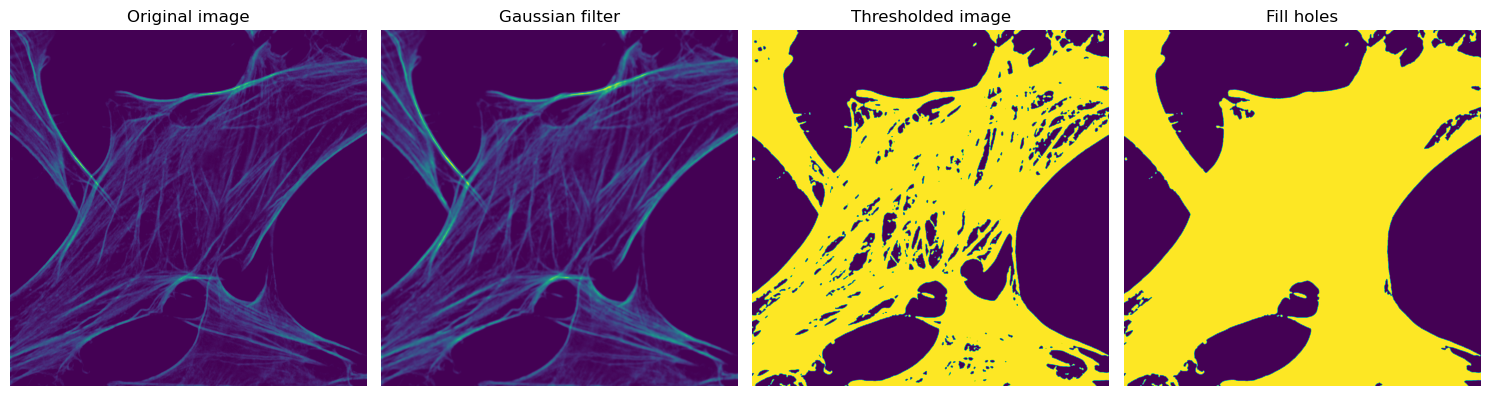

In [16]:
from scipy import ndimage as ndi

# smoothed the image using the Gaussian filter with the same sigma as before
smooth_actin = filters.gaussian(actin_float, sigma=3)

# find the optimal threshold
threshold = 0.5

# define the threshold mask
thresh_mask = smooth_actin > threshold

# fill holes to form the the actin_mask without performing the closing function
actin_mask = ndi.binary_fill_holes(thresh_mask).astype(int)

fig, axs = plt.subplots(1,4, figsize=(15, 15))
axs[0].imshow(actin)
axs[0].set_title('Original image')
axs[0].set_axis_off()

axs[1].imshow(smooth_actin)
axs[1].set_title('Gaussian filter')
axs[1].set_axis_off()

axs[2].imshow(thresh_mask)
axs[2].set_title('Thresholded image')
axs[2].set_axis_off()

axs[3].imshow(actin_mask)
axs[3].set_title('Fill holes')
axs[3].set_axis_off()

plt.tight_layout()


#### Distance transform and watershed
The next step will consists of computing the distance transform of the actin mask. An an exercise, observe how the value of the distance inside the regions change with the spatial coordinates. 

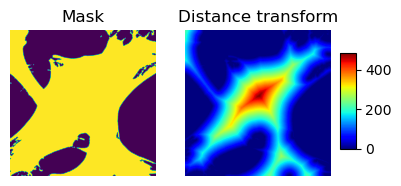

In [17]:
distance = ndi.distance_transform_edt(actin_mask) 

fig, ax = plt.subplots(1,3)

ax[0].imshow(actin_mask)
ax[0].set_title('Mask')
ax[0].set_axis_off()

im = ax[1].imshow(distance, cmap='jet')
ax[1].set_title('Distance transform')
ax[1].set_axis_off()

# insert the colorbar 
ax[2].set_position([0.64,0.4,0.025,0.2])
fig.colorbar(im, cax=ax[2]);


Now we set the nuclei we segemented before as the markers or seeds of the segmentations. We use the markers to label the segmented regions in the actin region. 
After, we watershed the negative inverse of the distance transform of the actin using the defined markers and within the mask delimited by the actin. The negative inverse of the distance is used in the watershed function instead of the distance because the goal is to have the objects region as valleys not peak.  

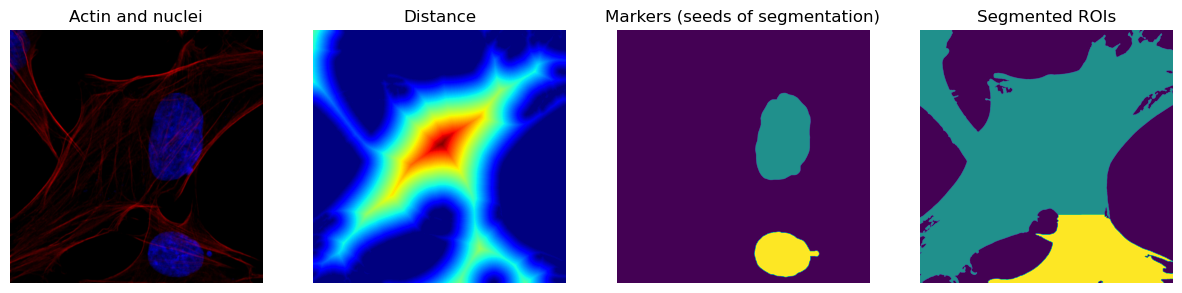

In [18]:
cell_label = segmentation.watershed(-distance, markers = nuclei_label, mask = actin_mask)

fig, ax = plt.subplots(1,4, figsize=(15, 15))

# create a RGB composite image to display the two channels (normalize channel in between 0 and 1)
rgb = np.stack([actin.astype(float) / actin.max(), 
                np.zeros(actin.shape), 
                nuclei.astype(float) / nuclei.max()], axis=2)

ax[0].imshow(rgb)
ax[0].set_axis_off()
ax[0].set_title('Actin and nuclei')

ax[1].imshow(distance, cmap='jet')
ax[1].set_title('Distance')
ax[1].set_axis_off()

ax[2].imshow(nuclei_label)
ax[2].set_title('Markers (seeds of segmentation)')
ax[2].set_axis_off()

ax[3].imshow(cell_label)
ax[3].set_title('Segmented ROIs')
ax[3].set_axis_off()

## Segmentation using Cellpose

Use a pretrained neural network for segmenting the image using two channels.

26-Jun-23 13:29:52 - cellpose.models - WARNING  - cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead


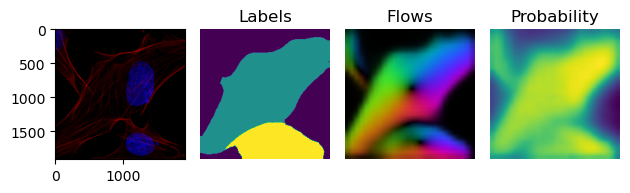

In [20]:
from cellpose import models

# Get the two channels from the data
data = image.data[0,[1,3],0,::10,::10].squeeze() 

# Get the pretrained model
model = models.Cellpose(gpu=False, model_type='cyto2')

# Evaluate the model 
mask, flows, styles, diams = model.eval(data, channels=[1,2], diameter=200)

# Display the results
fig, ax = plt.subplots(1,4)
ax[0].imshow(rgb)
ax[1].set_axis_off()
ax[1].imshow(mask)
ax[1].set_axis_off()
ax[1].set_title('Labels')
ax[2].imshow(flows[0])
ax[2].set_axis_off()
ax[2].set_title('Flows')
ax[3].imshow(flows[2])
ax[3].set_axis_off()
ax[3].set_title('Probability')
fig.tight_layout()

## Spot detection

To do the spot detection, we need to use what is called blob detection. Blob stands for Binary Large Object and refers to the connected pixel in the binary image. The blob detection method aims at detecting regions in a digital image that differ in properties, such as brightness or color, compared to surrounding regions. The Difference of Gaussian (DoG) method is one technique to detect blobs. For each blob found (a spot in our case), the method returns its coordinates position and the standard deviation of the Gaussian kernel that detected the spot. 


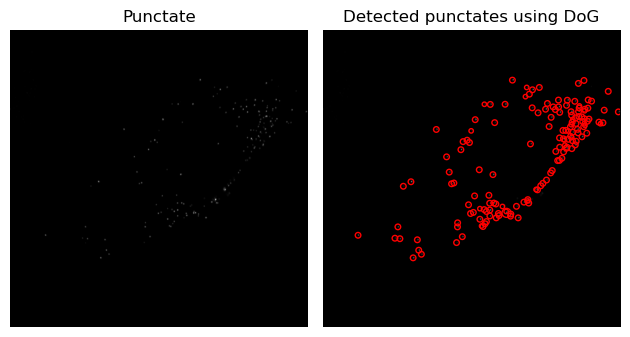

In [21]:
from skimage import feature 
import matplotlib.collections as mc

punctate = image.data[0,2,:,:].squeeze() # the image containing the punctate structure we want to detect

# Difference of Gaussian (DOG) return a (N,3) array with (row, columns and sigma)
coordinates = feature.blob_dog(punctate, max_sigma=10, threshold=0.01) 

# Visualization of the result
fig, ax = plt.subplots(1,2)

# Display the original image
ax[0].imshow(punctate,cmap='gray')
ax[0].set_title('Punctate')
ax[0].set_axis_off()

# Display the original image with an overlay of the detected spots
ax[1].imshow(punctate, cmap='gray') 
ax[1].add_collection(mc.CircleCollection(
        sizes = 5 * coordinates[:,2], offsets = coordinates[:,1::-1], 
        transOffset = ax[1].transData, color='red', facecolor='none'))
    
ax[1].set_axis_off()
ax[1].set_title('Detected punctates using DoG')

plt.tight_layout()
plt.show()

# Region properties

Now let use the ROI masks that we have just segmented and do the measurement we previously defined as our problems. For this, we use the regionprops function to measure the properties of the signal within the ROI mask. Below we display the countours of the ROIs.

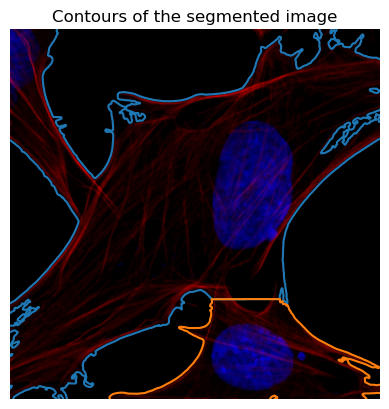

In [22]:
from skimage import measure

props = measure.regionprops(cell_label) # signal property: first argument is the mask ROI, second argument is the signal from which we are to extract any information of interest from

# Get a default list of colora
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Display the RGB composite image
plt.imshow(rgb)

# For earch region 
for k, p in enumerate(props):
    # Compute the contours
    contours = measure.find_contours(cell_label == p.label, 0.5)
    # For each elements of the contours
    for contour in contours:
        # Draw the contours 
        plt.plot(contour[:,1], contour[:,0], color=colors[k])

plt.axis('off')
plt.title('Contours of the segmented image');


## Maximum Intensity


In [23]:
import pandas as pd

signal = image.data[0,0].squeeze()

signal_table = measure.regionprops_table(cell_label, signal, properties=('label', 'intensity_max'))

results = pd.DataFrame(signal_table)

results

,label,intensity_max
0,1,19.0
1,2,12.0


In [24]:
import pandas as pd

signal = image.data[0,0].squeeze()

signal_props = measure.regionprops(cell_label, signal)
actin_props = measure.regionprops(cell_label, actin)

# Get the list of labels from the regions properties
labels = [p.label for p in signal_props]

# Get the maximum intensity for the properties
signal_max_intensity = [p.intensity_max for p in signal_props]
actin_max_intensity = [p.intensity_max for p in actin_props]

# Gather the results in a data frame (table)
results = pd.DataFrame({
    'Region label': labels, 
    'Signal [ch0] maximum intensity': signal_max_intensity,
    'Actin [ch1] maximum intensity': actin_max_intensity})

results


,Region label,Signal [ch0] maximum intensity,Actin [ch1] maximum intensity
0,1,19.0,49.0
1,2,12.0,33.0


## Defining a custom measurement

The information about the median is  not included in the image property that we can retrieve from regionprops. So here we show how can we do it using the information we can extract from the regionprops and numpy. The median of a list is defined as the middle element of the list when the list is sorted. 

In [25]:
# Define a custom function to measure median intensity
def median_intensity(mask, intensity):
    '''Median intenisty in a mask

    Parameters
    ----------
    mask : binary image
    intensity: intensity  image

    Returns
    -------
    The median intensity in the mask
    '''
    return np.median(intensity[mask])

actin_props = measure.regionprops_table(cell_label, actin, 
                                 properties = ('label','mean_intensity'), 
                                 extra_properties = (median_intensity,))

results = pd.DataFrame(actin_props)

results


,label,mean_intensity,median_intensity
0,1,4.276166,3.0
1,2,4.172375,3.0


## Number of dots
Now we are going to count how many dots are there in Channel-2 within the two regions defined by the ROIs. We use the knowledge we have acquired from Section. Spot detection to complete this task.


In [26]:
import pandas as pd

props = measure.regionprops(cell_label)

# Get the labels at the coordinates given by the blob detector
blob_cell_label = cell_label[coordinates[:,0].astype(int), coordinates[:,1].astype(int)]

# Get the list of labels from the regions properties
labels = [p.label for p in props]

# Compute the number of blob for each label
cell_num_blob = [np.sum(blob_cell_label == label)  for label in labels]

# Gather the results in a data frame (table)
results = pd.DataFrame({
    'Region label': labels, 
    'Number of punctate': cell_num_blob })

results

,Region label,Number of punctate
0,1,148
1,2,0


### Alternative approach using extra_properties

In [27]:
import pandas as pd

# Define a function to count the number of punctate in a region
def num_punctate(mask:np.ndarray, intensity:np.ndarray) -> int:
    '''Number of punctate in the mask

    Parameters
    ----------
    mask      : binary image for the region
    intensity :  binary image indicating the presence of a blob

    Returns
    -------
    The number of puncates in the region
    '''
    return int(intensity[mask].sum())

# Create a mask for the blobs
blob_mask = np.zeros(cell_label.shape)
blob_mask[coordinates[:,0].astype(int), coordinates[:,1].astype(int)] = 1

props = measure.regionprops_table(cell_label, blob_mask, 
                          properties = ('label',),
                          extra_properties = (num_punctate, ))

results = pd.DataFrame(props)

results

,label,num_punctate
0,1,148
1,2,0


We can also rename the columns to be more descriptive:

In [28]:
results = results.rename(columns = {'label':'Region label', 'num_punctate':'Number of punctate'})
results

,Region label,Number of punctate
0,1,148
1,2,0


# Exporting tabular results

To save results in a csv file use the export function from pandas.


In [49]:
results.to_csv('results.csv')

# Some more helpful tips

- Take good images
- Housekeeping labels